### libraries

In [1]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import glob

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torchvision.models.video import r2plus1d_18
from torchvision.transforms.functional import InterpolationMode

# from torchvision.transforms import v2
# !pip install git+https://github.com/facebookresearch/fvcore.git


from sklearn.metrics import confusion_matrix
import seaborn as sns

### Initialization

In [2]:
pwd

'/scratch/student/shokoofa/video analysis/Fold 1/code'

In [3]:
original_address = '/scratch/student/shokoofa/complete_dataset_f1/'

In [4]:
paths = glob.glob(os.path.join(original_address + '**/*', '*')) #numebr of all samples per patients
len(paths)

79583

### Load the csv file containing the image file names and corresponding labels

In [5]:
info_train = pd.read_csv(os.path.join(original_address , 'train_label_sw16.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'val_label_sw16.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'test_label_sw16.csv'))

In [6]:
info_test.label.unique()

array(['PLAX', 'PSAX-ves', 'PSAX-base', 'PSAX-mid', 'PSAX-apical',
       'Apical-4ch', 'Apical-3ch', 'Subcostal', 'Apical-5ch',
       'Apical-2ch', 'Suprasternal'], dtype=object)

In [7]:
# info_train = pd.read_csv(os.path.join(original_address , 'train_labels_psax.csv'))
# info_val = pd.read_csv(os.path.join(original_address , 'val_labels_psax.csv'))
# info_test = pd.read_csv(os.path.join(original_address , 'test_labels_psax.csv'))

### Get data distribution 

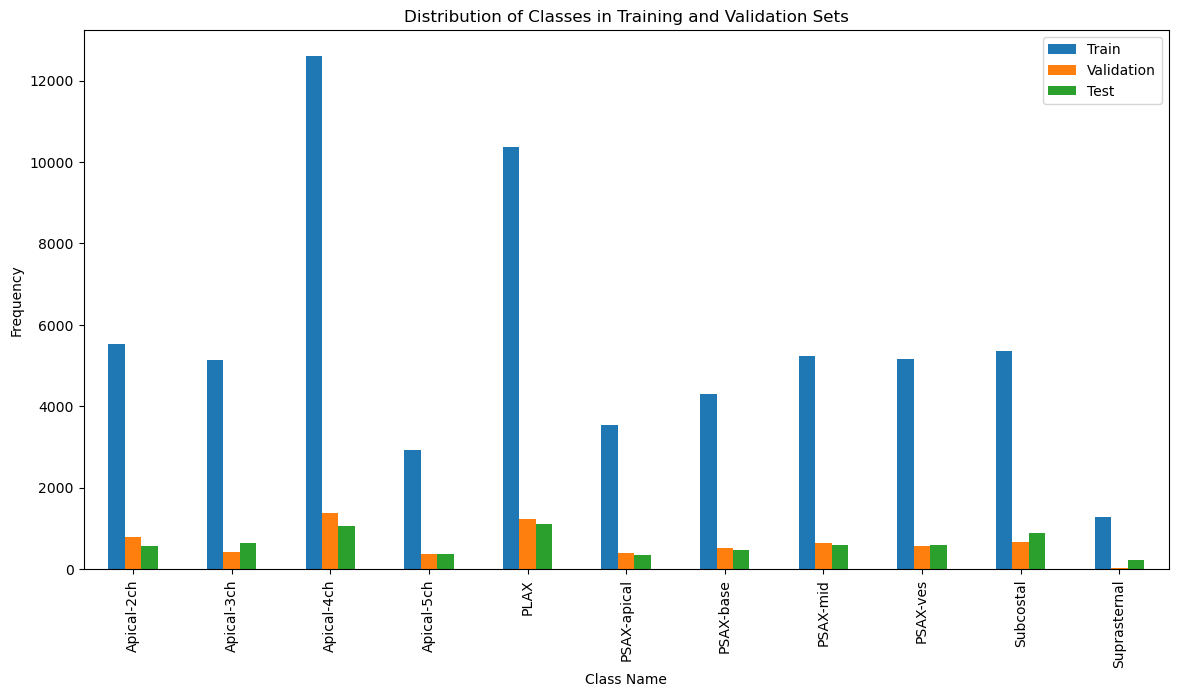

In [8]:
train_dict = info_train['label'].value_counts().to_dict()
val_dict =info_val['label'].value_counts().to_dict()
test_dist_dict = info_test['label'].value_counts().to_dict() 

all_classes = set(train_dict.keys()).union(set(val_dict.keys()))
train_dict_full = {cls: train_dict.get(cls, 0) for cls in all_classes}
val_dict_full = {cls: val_dict.get(cls, 0) for cls in all_classes}
test_dict_full = {cls: test_dist_dict.get(cls, 0) for cls in all_classes}

df_counts = pd.DataFrame({'Train': train_dict_full, 'Validation': val_dict_full, 'Test': test_dict_full})

df_counts = df_counts.sort_index()

# df_counts = pd.DataFrame({'Train': train_counts, 'Validation': val_counts})

# Plot
ax = df_counts.plot(kind='bar', figsize=(14, 7))
ax.set_xlabel("Class Name")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Classes in Training and Validation Sets")

# Show the plot
plt.show()

### Define Transformers

In [9]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = h // 15
        left = w // 10
        return img.crop((left, top, w, new_h))


to_pil = ToPILImage()


all_data_transform = transforms.Compose([
    CustomCrop(),
    # transforms.Resize([128, 171], interpolation=InterpolationMode.BILINEAR),
    
    # transforms.Resize((224, 224)), #resNext50
    # transforms.Resize((256, 256)), #efficientNet-b0
    transforms.Resize((288, 288)), #efficientNet-b2
    # transforms.Resize((275, 275)), 
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    # transforms.CenterCrop([112, 112]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
    # Lambda(lambda x: x/255),
])


### Same augmentation to all frames of a sample

In [10]:
class AddGaussianNoise:
    """Adds Gaussian noise to a tensor."""
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

class ApplySameTransformToAllFrames:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(brightness=0.1, contrast=0.4)
        self.center_crop = transforms.CenterCrop(180)

    def get_random_parameters(self):
        # This will generate a new set of random parameters each time it's callednfo_train['path'], info_train['label'],info_train['start'], info_train['end']
        params = {
            'do_horizontal_flip': random.random() < 0.2,
            'do_vertical_flip': random.random() < 0.2,
            'angle': random.uniform(-10, 10),
            'apply_color_jitter': random.random() < 0.2,
            'apply_noise': random.random() < 0.2,
            'center_crop': random.random() < 0.4
        }
        return params

    def __call__(self, list_of_images):
        # Convert to PIL Images if needed
        list_of_images = [Image.fromarray(image) if isinstance(image, np.ndarray) else image for image in list_of_images]
        pars = self.get_random_parameters()

        # Apply the same transformations to all frames in this sample
        transformed_images = [self.apply_random_transforms(img, pars) for img in list_of_images]
        return transformed_images

    def apply_random_transforms(self, img, params):

        # if params['do_horizontal_flip']:
        #     img = TF.hflip(img)
        if params['do_vertical_flip']:
            img = TF.vflip(img)
        img = TF.rotate(img, params['angle'])
        if params['apply_color_jitter']:
            img = self.color_jitter(img)
        img = self.to_tensor(img)
        if params['apply_noise']:
            img = AddGaussianNoise()(img)
        if params['center_crop']:
            img = self.center_crop(img)
            img = transforms.Resize((288, 288))(img) #TODO : change this as you resize 

        return img

#### Test Time Augmentation

In [11]:
class TestTimeAugmentation:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(brightness=0.1, contrast=0.4, saturation=0, hue=0)

    def get_random_parameters(self):
        # Generate a new set of random parameters for each test instance
        params = {
            'do_horizontal_flip': random.random() < 0.2,
            'do_vertical_flip': random.random() < 0.2,
            'angle': random.uniform(-10, 10),
            'apply_color_jitter': random.random() < 0.2,
            'apply_noise': random.random() < 0.2
        }
        return params

    def __call__(self, list_of_images):
        # Convert to PIL Images if needed
        list_of_images = [Image.fromarray(image) if isinstance(image, np.ndarray) else image for image in list_of_images]
        pars = self.get_random_parameters()

        # Apply the same transformations to all frames in this sample
        transformed_images = [self.apply_random_transforms(img, pars) for img in list_of_images]
        return transformed_images

    def apply_random_transforms(self, img, params):
        # if params['do_horizontal_flip']:
        #     img = TF.hflip(img)
        # if params['do_vertical_flip']:
        #     img = TF.vflip(img)
        img = TF.rotate(img, params['angle'])
        if params['apply_color_jitter']:
            img = self.color_jitter(img)
        img = self.to_tensor(img)
        if params['apply_noise']:
            img = AddGaussianNoise()(img)

        return img

### Map images to their labels

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, starts, ends, transform, training_transform = False):
        self.paths = paths
        self.labels = labels
        self.starts = starts
        self.ends = ends
        self.transform = transform
        self.training_transform = training_transform
        self.transform = transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }
        self.labels_require_aug = [3, 4, 10, 6, 7] # PSAX-apical, PSAX-mid, suprasternal, apical-3ch, apical 5-ch 

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

        output = image_array * mask
        return output

    def address(self,index):
        return original_address + self.paths[index]
    
    def __getitem__(self, index):
        filepath = original_address + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])

        # sort the image in based on the order of the slices saved in the folder
        # imgs_paths = sorted(glob.glob(os.path.join(filepath, '*')), key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))
        addresses = []
        for i in range(self.starts[index], self.ends[index]+1, 3):
            addresses.append(filepath + '/' + filepath.split('/')[-2] + '_' + str(i) + '.jpeg')

        imgs_paths = sorted(addresses, key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))

        images_list = []
        for img_path in imgs_paths:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)


        # creating a 3D tensor image
        sequence_tensor = torch.stack(images_list)
        # chunks = self.sliding_window(sequence_tensor)
        
        preprocessed_d = self.preprocessing(sequence_tensor)
            

        # video augmentation on all slices
        if self.training_transform:
            # and label in self.labels_require_aug:
            preprocessed_d = np.stack([to_pil(image) for image in preprocessed_d])
            train_transform = ApplySameTransformToAllFrames()
            preprocessed_d = train_transform(preprocessed_d)
            preprocessed_d = torch.stack([image for image in preprocessed_d])

        # Return the image and label as tensors
        return preprocessed_d, label


In [13]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [14]:
train_data = CustomDataset(info_train['path'], info_train['label'],info_train['start'], info_train['end'], transform=all_data_transform, training_transform = True)
val_data = CustomDataset(info_val['path'], info_val['label'],info_val['start'], info_val['end'], transform=all_data_transform, training_transform = False)
test_data = CustomDataset(info_test['path'], info_test['label'],info_test['start'], info_test['end'], transform=all_data_transform, training_transform = False)

### visualization 

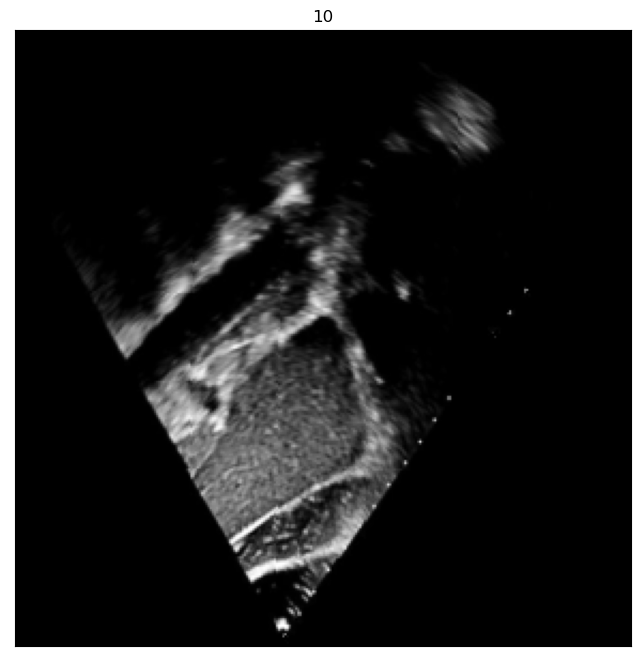

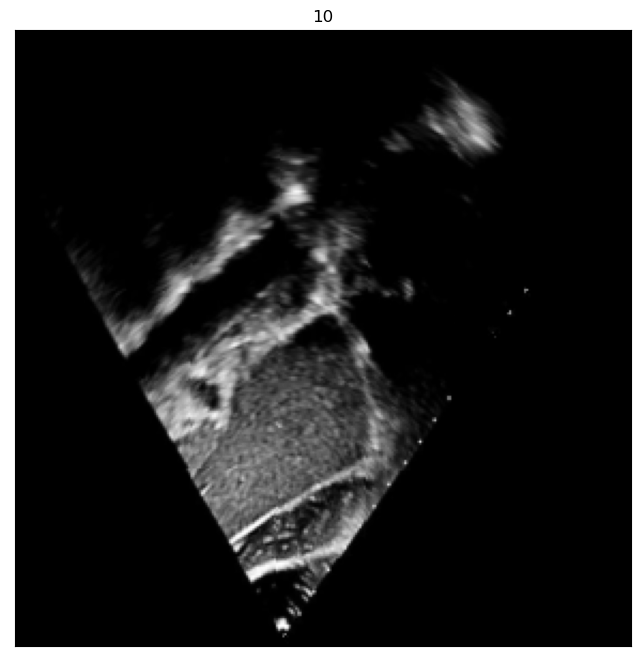

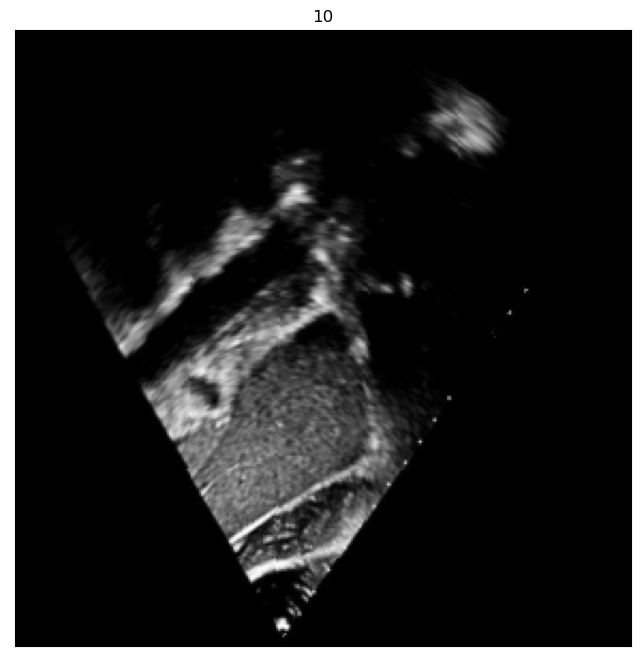

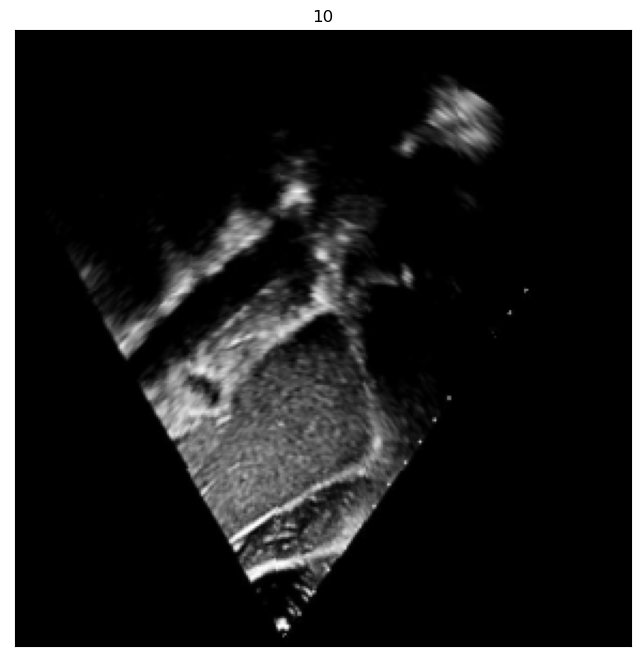

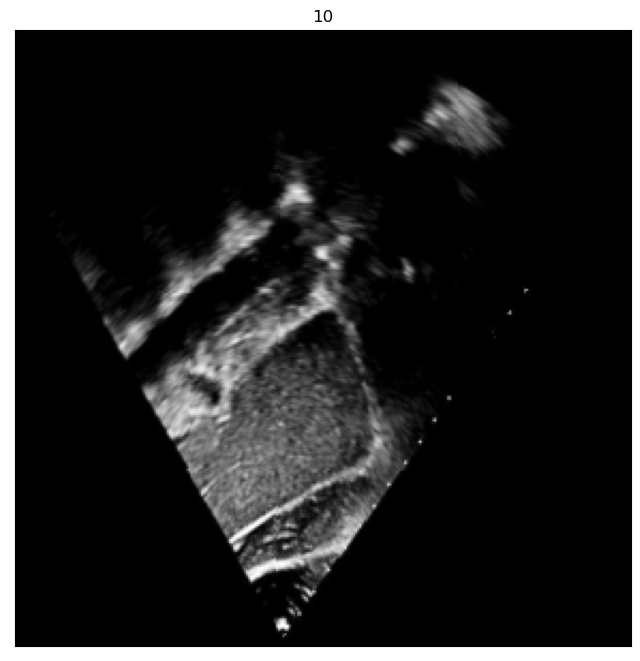

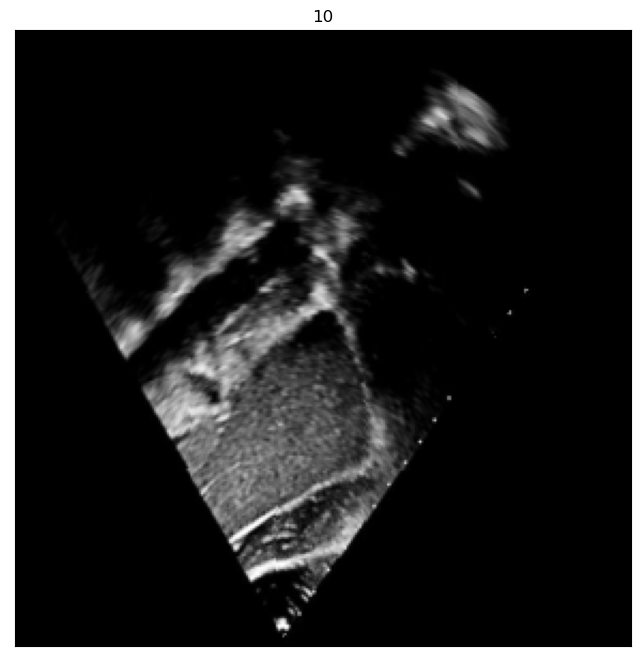

In [15]:
dt = train_data[10][0][:]
lb = train_data[10][1]
num  = len(dt)
for i in range(num):
    visualization(dt[i,-1], lb)
    
# dt1 = train_data[60][0][:]
# lb1 = train_data[60][1]
# for i in range(num):
#     visualization(dt1[i,-1], lb1)

### Create data loaders for the train and validation sets



In [16]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=False, shuffle=False, pin_memory=True, num_workers= 8)
#pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=False, shuffle=False, pin_memory=True, num_workers= 8)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [17]:
# for img, lbl in train_loader:
#     print(img.shape)
#     break

### Define the neural network model architecture

In [42]:
class ResidualCombination(nn.Module):
    def __init__(self, feature_dim):
        super(ResidualCombination, self).__init__()
        # Linear layers to reduce and then restore the feature_dim
        self.fc1 = nn.Linear(feature_dim, feature_dim // 2)  # First linear layer
        self.fc2 = nn.Linear(feature_dim // 2, feature_dim)  # Second linear layer

    def forward(self, x):
        # x shape: (batch_size, seq_len, feature_dim)
        x = torch.relu(self.fc1(x))  # Linear over the last dimension
        x = self.fc2(x)  # Linear over the last dimension
        alpha = torch.sigmoid(x)  # Get alpha values between 0 and 1
        return alpha

class ConvWeighting(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(ConvWeighting, self).__init__()
        self.hidden_size = 1408
        self.num_heads = 2
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        self.feature = torchvision.models.efficientnet_b2(weights='DEFAULT').features
        self.mhsa = nn.MultiheadAttention(self.cnn_output_size, self.num_heads, batch_first=True)
        self.classifier_layer = nn.Sequential(nn.Dropout(0.2), nn.Linear(self.hidden_size, num_classes))

        # Add the ResidualCombination module
        self.residual_combination = ResidualCombination(feature_dim=1408)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()
        c_in = x.view(batch_size * seq_len, C, H, W)
        f_out = self.feature(c_in)

        f_out = torch.mean(f_out, dim=[2, 3])  # Spatial averaging
        spatial = f_out.view(batch_size, seq_len, -1)  # Latent spatial feature vector
        temporal, _ = self.mhsa(spatial, spatial, spatial)

        # Concatenate along the time dimension
        cat_feature = torch.cat([spatial, temporal], dim=1)  # Shape: (8, 12, 1408)
        # print(cat_feature.shape)

        # Use the residual combination module (operate on the last dimension)
        residual = self.residual_combination(cat_feature)  # Shape: (8, 12, 1408)

        # Apply the classifier to the mean of the sequence dimension
        output = self.classifier_layer(residual.mean(dim=1))  # Shape: (8, num_classes)
        return output, torch.softmax(output, dim=1), residual

model = ConvWeighting(3, 1408, 11)

### simple model test

In [36]:
# input1 = torch.rand(8, 10, 3, 299, 299)
input2 = torch.rand(8, 6, 3, 299, 299)
model.eval()
# print(model(input1))
print(model(input2)[0].shape)

torch.Size([8, 12, 1408])
torch.Size([8, 11])


### Define loss and optimizer

In [64]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0
# !nvidia-smi
# torch.cuda.empty_cache()

True

#### Noramal loss

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
# model.lstm.flatten_parameters() 
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.9)

print(device)

Let's use 2 GPUs!
cuda


### Train the model

In [66]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs, _ = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print(predictions, labels, labels == predictions, total_correct, total, images.size(0))

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [67]:
# model = model.to(device)
epochs = 5
# BATCH_SIZE = 64
accs = []
losses = []
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  val_loss = 0.0
  # epochs_no_improve = 0
  best_val_loss = float('inf')
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs, _ = model(images)
    # print(images)
    # print(outputs)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    # print(predictions, labels)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, criterion, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), (f'test{epoch}-newmodel-mhsa.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 3:
    print('no further improvement')
    break


Train epoch 0: Loss(0.9657, Accuracy (0.66460) )
valid epoch 0: Loss(0.8615),  Accuracy (0.7332))
---
Train epoch 1: Loss(0.5022, Accuracy (0.82791) )
valid epoch 1: Loss(0.7344),  Accuracy (0.8025))
---
Train epoch 2: Loss(0.2902, Accuracy (0.90604) )
valid epoch 2: Loss(0.5367),  Accuracy (0.8547))
---
Train epoch 3: Loss(0.1947, Accuracy (0.93797) )
valid epoch 3: Loss(0.6263),  Accuracy (0.8626))
---
Train epoch 4: Loss(0.1435, Accuracy (0.95505) )
valid epoch 4: Loss(0.8120),  Accuracy (0.8298))
---


/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


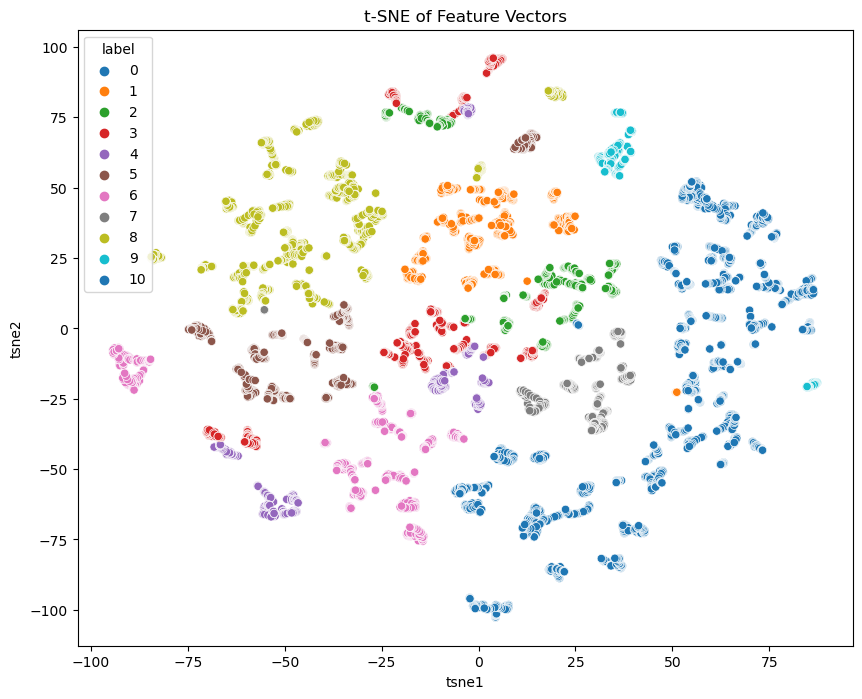

In [ ]:
from sklearn.manifold import TSNE
# Assuming your model is named model
# Remove DataParallel wrapper if present
if isinstance(model, torch.nn.DataParallel):
    model = model.module

# Set the model to evaluation mode
model.eval()

cols = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10}

# Function to extract features
def extract_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.append(output[0].cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)


# Extract features
features, labels = extract_features(model, test_loader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
df_tsne['label'] = labels

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne1', y='tsne2', hue='label', palette='tab10', data=df_tsne, legend='full')
plt.title('t-SNE of Feature Vectors')
plt.show()

### Load pre-trained model 

In [43]:
# device = torch.device('cuda:0')
# Load your model and ensure all its parameters are on the default device
model = ConvWeighting(3,1408, 11)
state_dict = torch.load('test4-newmodel-mhsa.pth', map_location='cpu')
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)
# model = nn.DataParallel(model, device_ids=[0, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# model = CNNLSTM(3, 1000, 11)
# model.load_state_dict(torch.load('customizedEN6-acc86-loss0.5.pth'))
# model = nn.DataParallel(model, device_ids=[0,1])
# model.eval()


# model = CNNLSTM(3, 1000, 11)  # adjust according to your model definition
# state_dict = torch.load('customizedEN6-acc86-loss0.5.pth', map_location='cpu')
# # Create a new state dictionary with the module prefix removed
# new_state_dict = {k[len("module."):]: v for k, v in state_dict.items()}
# model.load_state_dict(new_state_dict)
# model.eval()

### Test without ensembling 

In [46]:
def evaluate_test(model, loader, device, mode='Test'):
    model.eval()
    indices = []
    predicted_labels = []
    true_labels = []
    confidences = []
    alphas = []
    total_correct = 0
    total_loss = 0
    # BATCH_SIZE = 64
    total = 0
    for enum, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)
        with torch.no_grad():
            outputs, confidence, alpha = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            total += images.size(0) 
            _, predictions = outputs.max(1)
            total_correct += (labels == predictions).sum()
            batch_start = enum * loader.batch_size
            batch_indices = list(range(batch_start, batch_start + images.size(0)))
            alphas.extend(alpha.cpu().numpy())
            confidences.extend(confidence.cpu().numpy())
            indices.extend(batch_indices)
            predicted_labels.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        # print(total_correct, total, accuracy)
    loss = total_loss / total
    accuracy = total_correct / total
    print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
    test_dict = {'indices': indices, 'predicted': predicted_labels, 'true_labels': true_labels, 'confidence_score': confidences, 'alpha': alphas}
    return accuracy, loss, test_dict


### evaluate test

In [41]:
model.residual_combination

ResidualCombination(
  (fc1): Linear(in_features=1408, out_features=704, bias=True)
  (fc2): Linear(in_features=704, out_features=1408, bias=True)
)

In [47]:
_, _, test_dict = evaluate_test(model, loader= test_loader, device = device)

Test Loss(0.4250),  Accuracy (0.8874))


In [63]:
res2['alpha'][2].shape

(12, 1408)

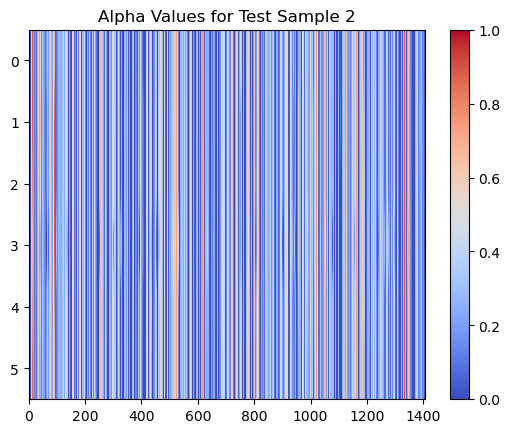

0.2646066


In [68]:
sample_alpha = test_dict['alpha'][2]
# Visualize alpha values for this sample
plt.imshow(sample_alpha[:6], cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title(f'Alpha Values for Test Sample {2}')
plt.show()

print(sample_alpha[:6].mean())

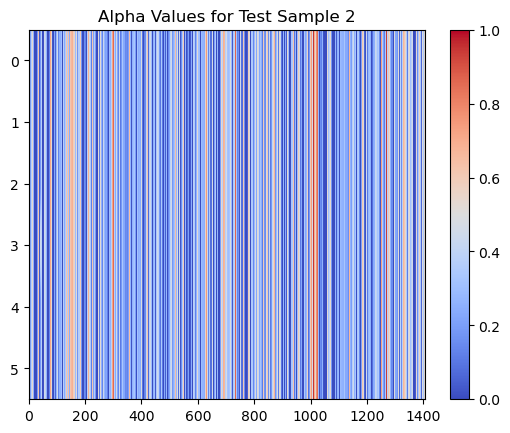

0.28633997


In [70]:
sample_alpha = test_dict['alpha'][2]
# Visualize alpha values for this sample
plt.imshow(sample_alpha[6:], cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title(f'Alpha Values for Test Sample {2}')
plt.show()

print(sample_alpha[6:].mean())

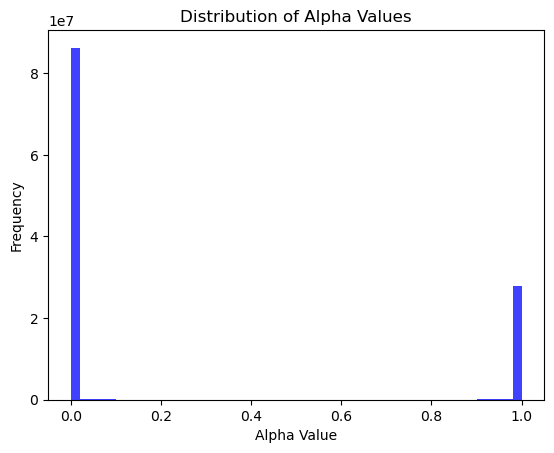

In [56]:
import matplotlib.pyplot as plt

# Assuming alpha has shape (batch_size, seq_len, feature_dim)
alpha_values = np.concatenate([alpha.flatten() for alpha in test_dict['alpha']])
plt.hist(alpha_values, bins=50, alpha=0.75, color='b')
plt.xlabel('Alpha Value')
plt.ylabel('Frequency')
plt.title('Distribution of Alpha Values')
plt.show()


In [62]:
# mapping the predicted df to the true df of test set
test_df = pd.DataFrame(test_dict)
test = pd.concat([test_df, info_test], axis = 1)
test
def get_mode(series):
    return series.mode()[0] if not series.mode().empty else None

def get_mean(series):
    return series.mean()

res = test.groupby(['path', 'true_labels']).agg({ 'confidence_score': get_mean, 'alpha': get_mean} ).reset_index() 
res['predicted'] = res['confidence_score'].apply(lambda x : x.argmax())
res
def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    print(correct)
    total = len(true_labels)
    print(total, total - correct)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res['true_labels'], res['predicted']
print(calculate_accuracy(true_labels, pred_labels))
res['same_video'] = res['path'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1]))
res2 = res.groupby(['same_video', 'true_labels']).agg({'confidence_score': get_mean, 'alpha': get_mean}).reset_index() 
res2['predicted'] = res2['confidence_score'].apply(lambda x: x.argmax())
res2
def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total = len(true_labels)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res2['true_labels'], res2['predicted']
calculate_accuracy(true_labels, pred_labels)

461
503 42
0.9165009940357853


0.9149797570850202

In [ ]:
res.to_csv('f1-RTSB-lstm-alpha-acc94.csv', index=False)

In [ ]:
torch.save(model.state_dict(), (f'RTSB-lstm-alpha-acc94.pth'))

### Confusion matrix

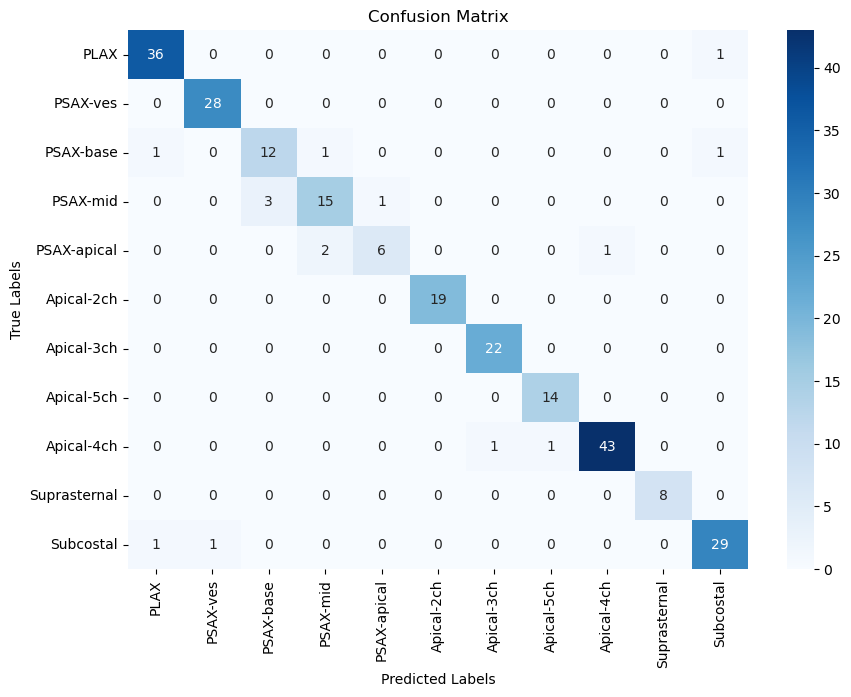

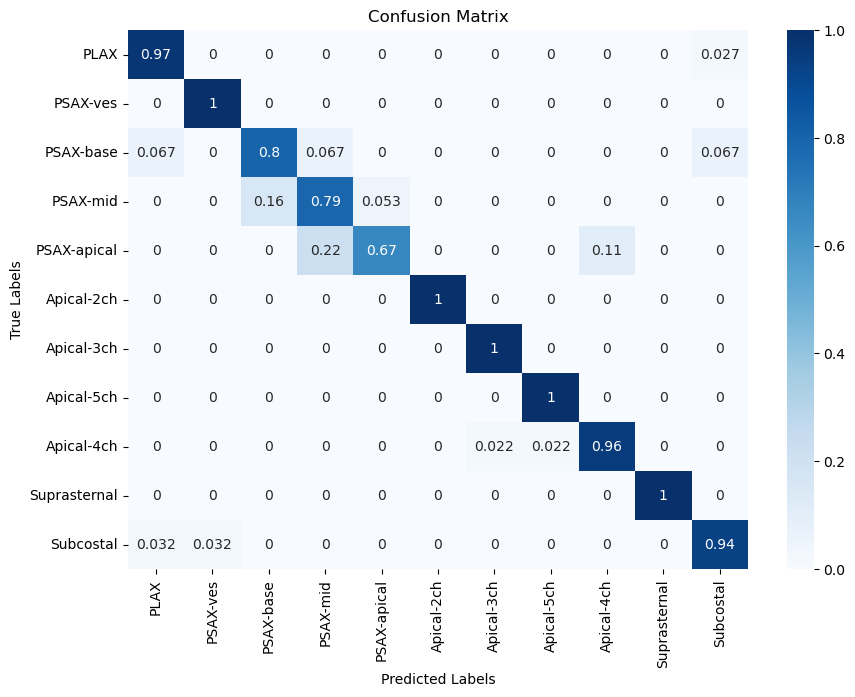

In [ ]:
true_labels, pred_labels = res2['true_labels'], res2['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

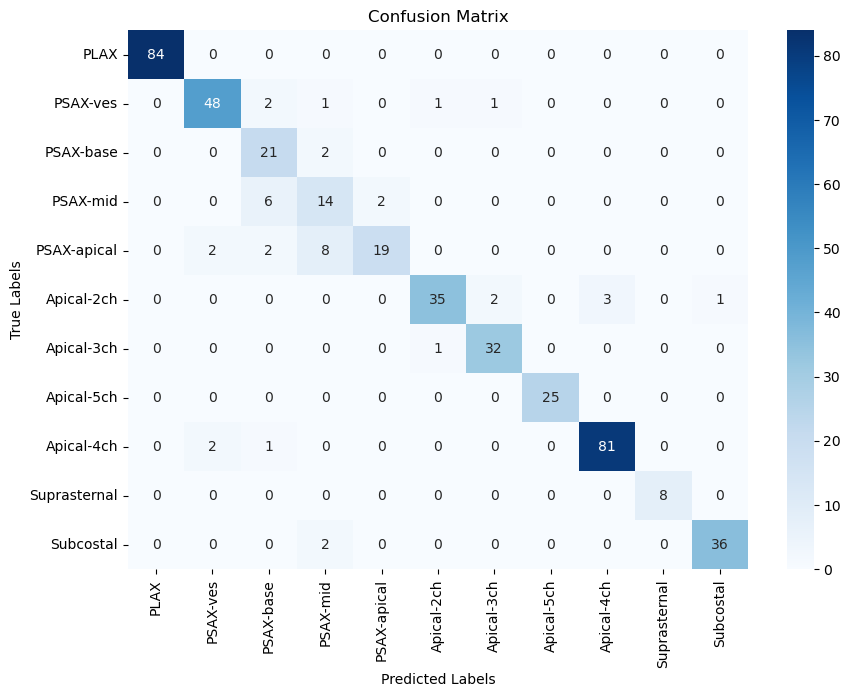

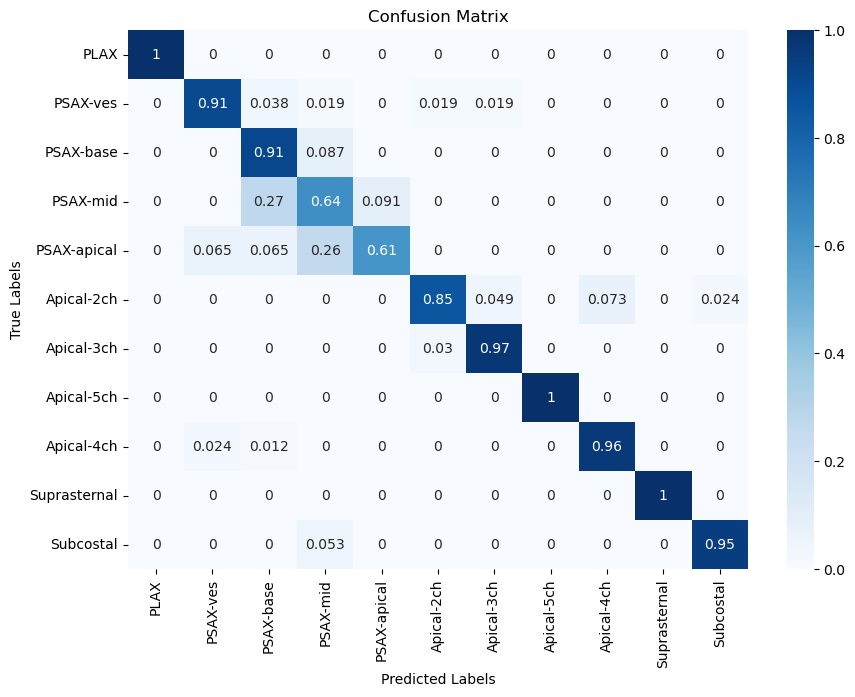

In [ ]:
true_labels, pred_labels = res['true_labels'], res['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
res2['true_labels'] = res2['true_labels'].apply(lambda x : 3 if x==4 else x)
res2['predicted'] = res2['predicted'].apply(lambda x : 3 if x==4 else x)
calculate_accuracy(res2['true_labels'], res2['predicted'])

0.9433198380566802

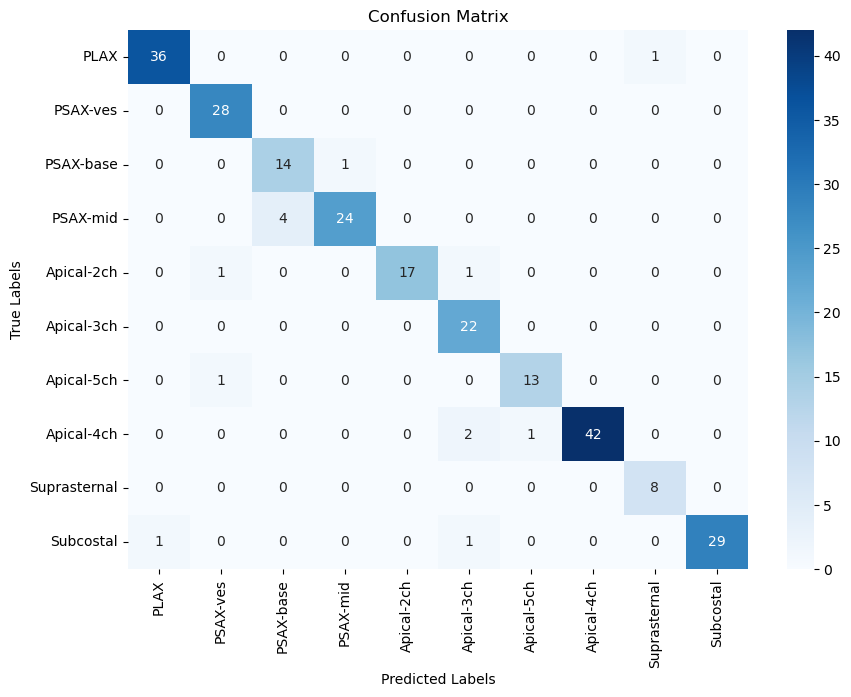

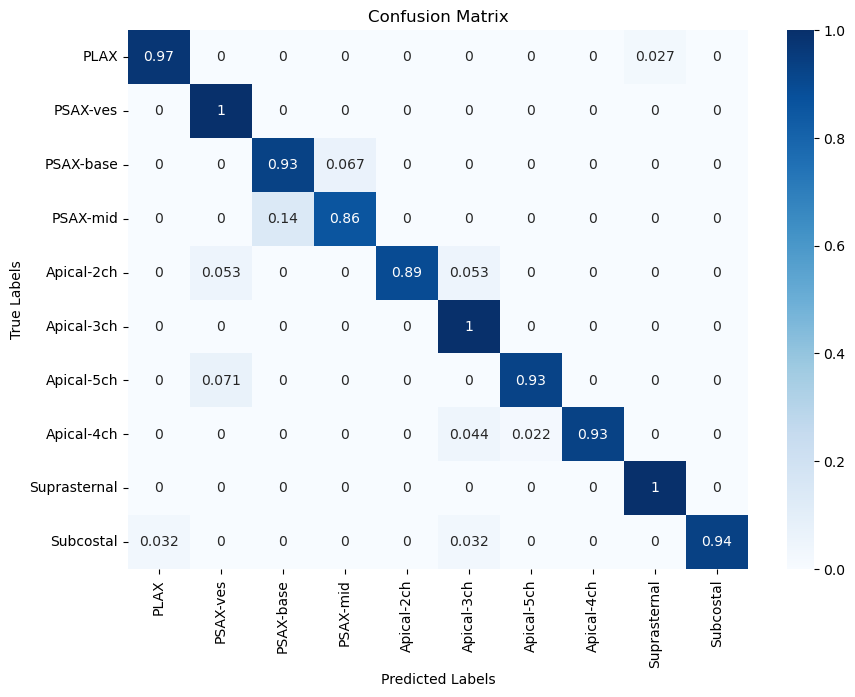

In [ ]:
true_labels, pred_labels = res2['true_labels'], res2['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                             'Apical-2ch' : 4, 'Apical-3ch' : 5,
                              'Apical-5ch' : 6, 'Apical-4ch' : 7, 'Suprasternal' : 8, 'Subcostal' : 9
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

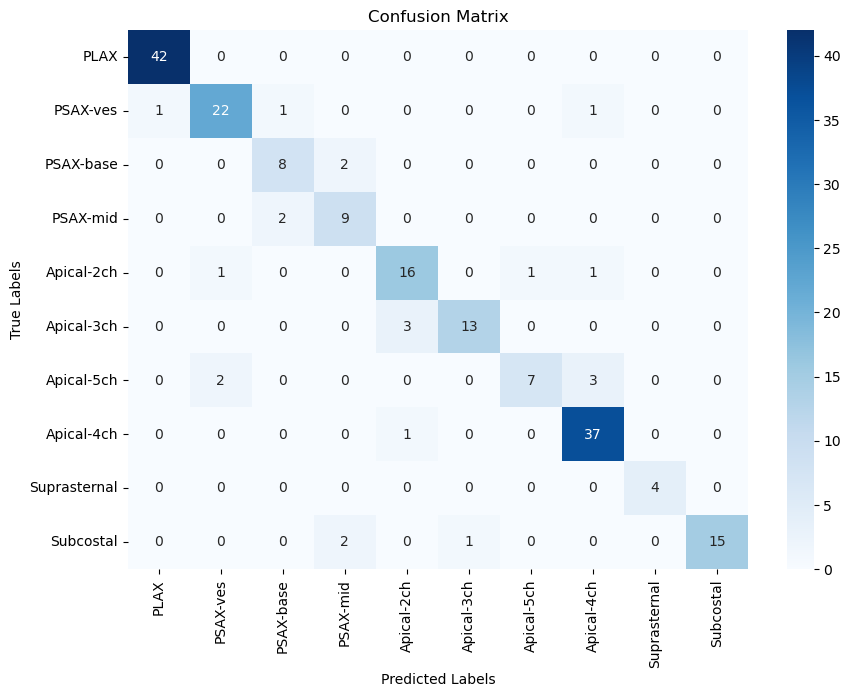

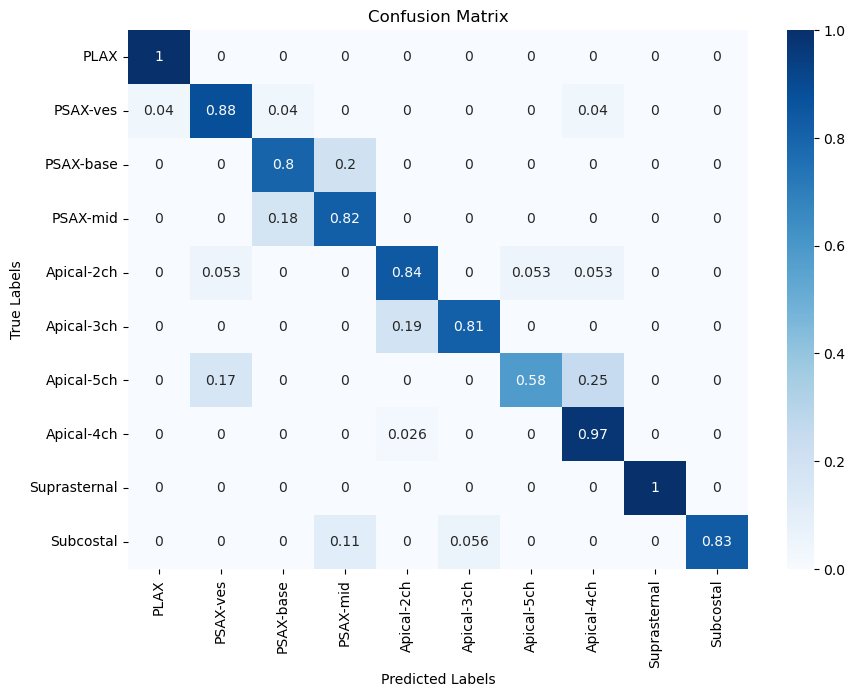

In [ ]:
true_labels, pred_labels = res['true_labels'], res['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'Apical-2ch' : 4, 'Apical-3ch' : 5,
                              'Apical-5ch' : 6, 'Apical-4ch' : 7, 'Suprasternal' : 8, 'Subcostal' : 9
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

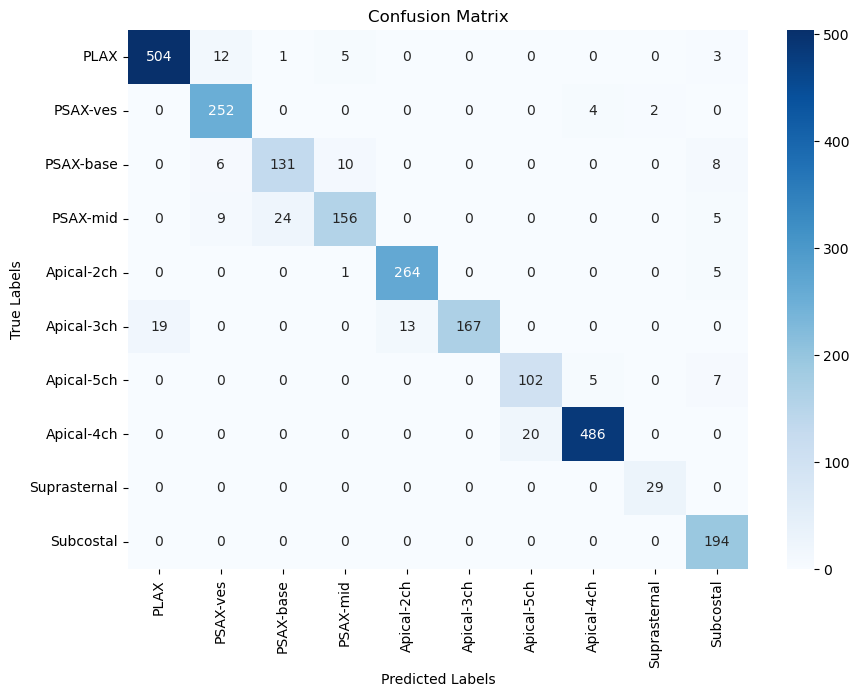

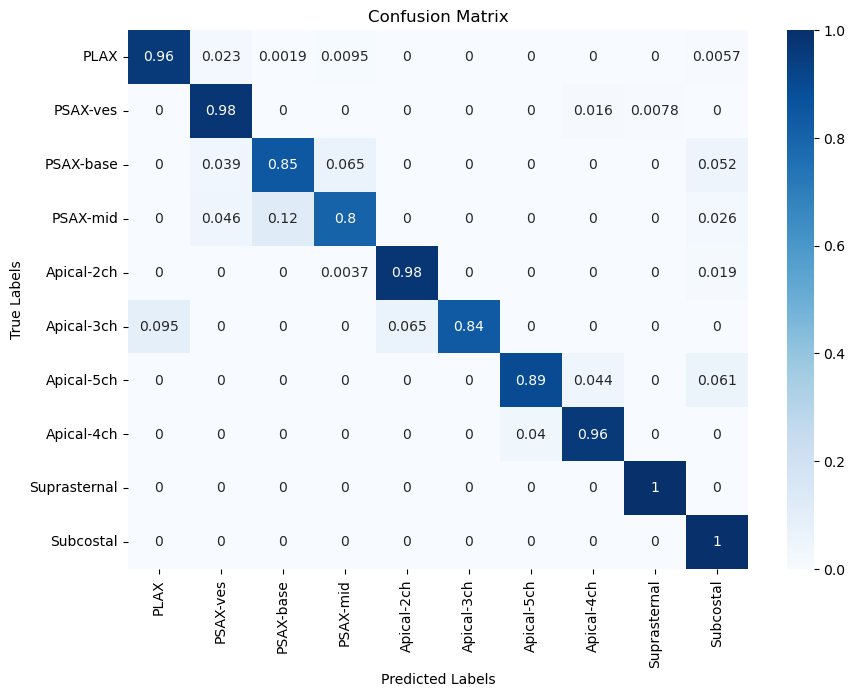

In [ ]:
true_labels, pred_labels = test['true_labels'], test['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'Apical-2ch' : 4, 'Apical-3ch' : 5,
                              'Apical-5ch' : 6, 'Apical-4ch' : 7, 'Suprasternal' : 8, 'Subcostal' : 9
                            }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

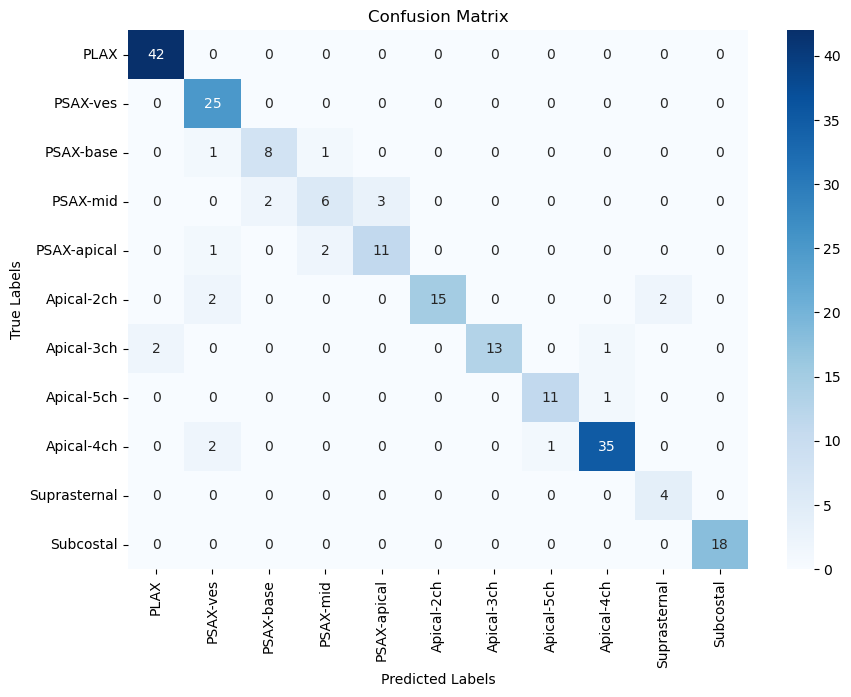

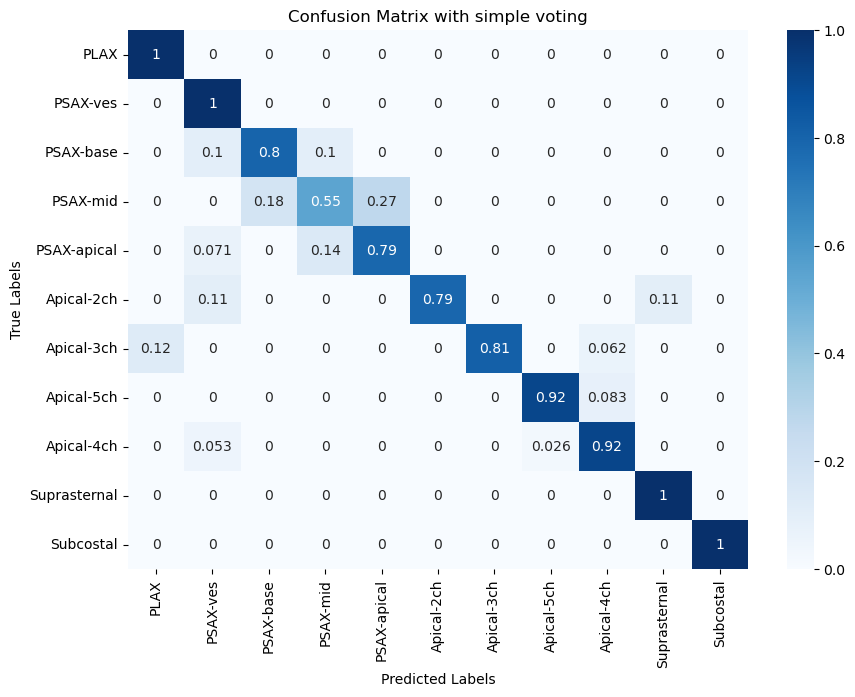

In [ ]:
true_labels, pred_labels = res['true_labels'], res['predicted']
# valid_labels = {'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3, 'PSAX-apical' : 4 }
valid_labels = {'PLAX':0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with simple voting')
plt.show()

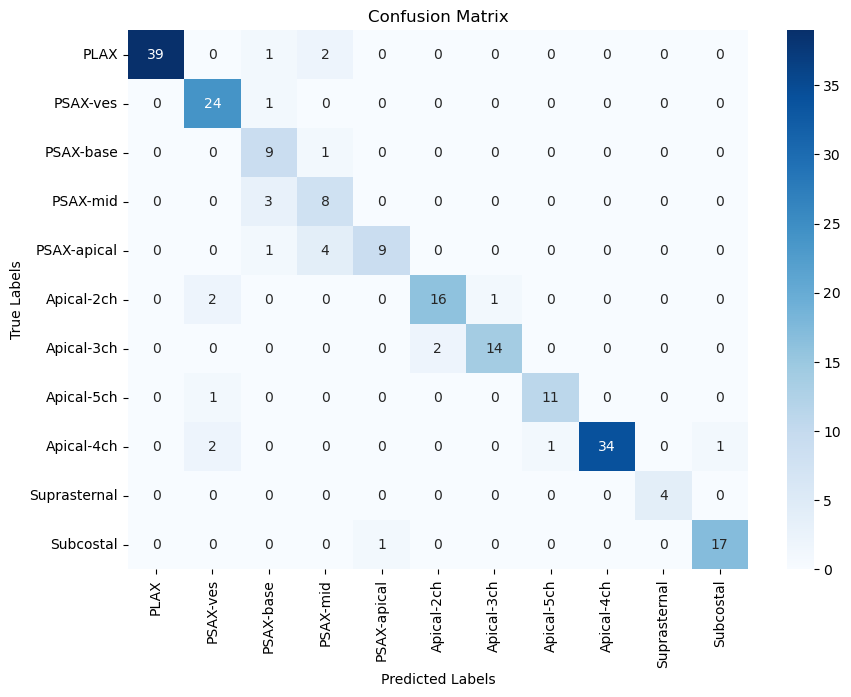

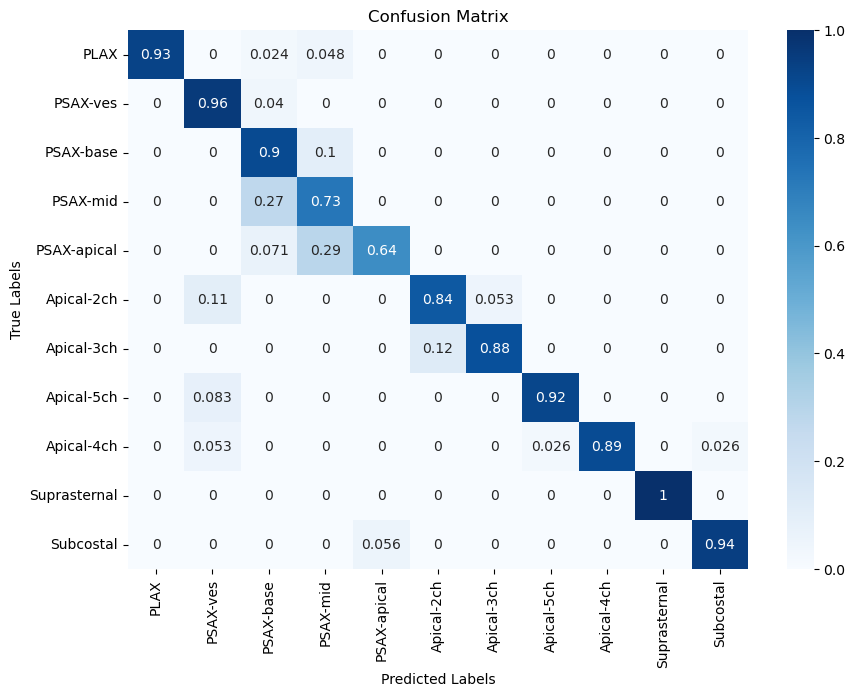

In [ ]:
true_labels, pred_labels = aggregated_results['true_labels'], aggregated_results['final_prediction']

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


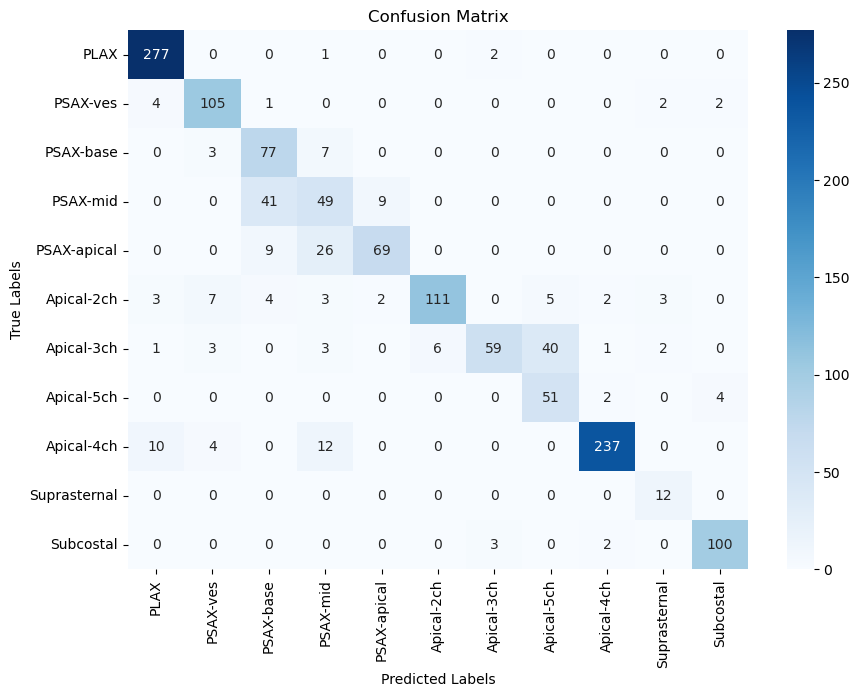

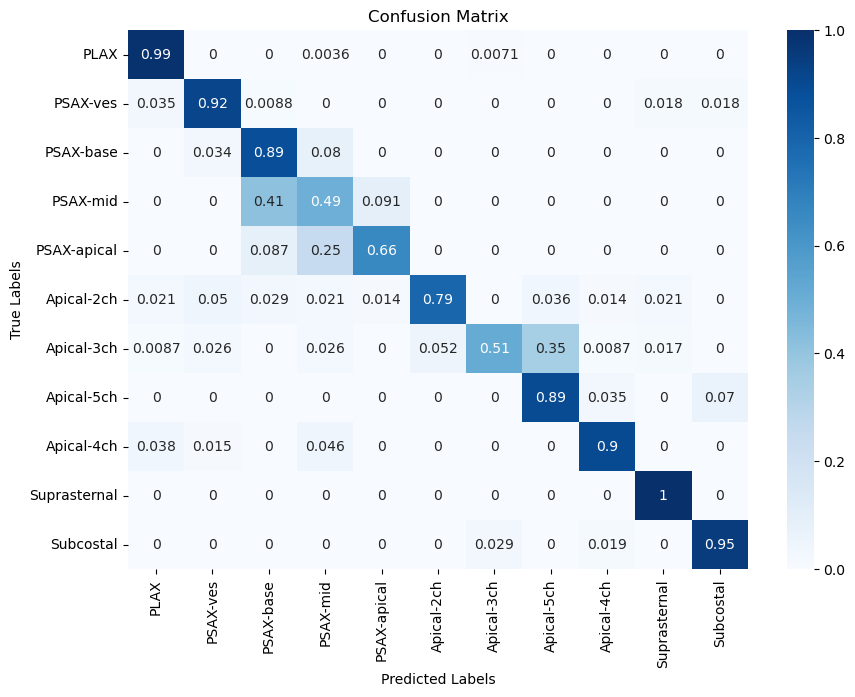

In [ ]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()